# Response Classification

Supervised ML technique to predict our binary response variable (using k-nearest neighbors (kNN)). Unlike clustering, our examples are labeled, so this exercise is predictive as opposed to our descriptive slustering from the prior notebook.

In [1]:
# packages
import pandas as pd
import os
import warnings
from dotenv import load_dotenv
from google.cloud import bigquery
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

# classification
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
# retreive data from bigquery

load_dotenv()
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Initialize the BigQuery Client
client = bigquery.Client()

# BQ query
sql_query = """
    SELECT 
        * 
    FROM `crudek-data.practice_data.marketing_campaign_clean`             
"""

query_job = client.query(
    sql_query)

# retreive and convert the result to a Pandas DataFrame
df = query_job.to_dataframe()

### Data Preparation
Remeber, a majority of the data preparation work was completed in the *1_data_preparation* notebook within this repo. If needed, go back and familiarize yourself with the following steps that were taken:
1. EDA
2. Handle missing data
3. Handle outliers
4. Create new features
5. Remove certain fields

In [3]:
df.head()

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,Complain,Response,CustomerAge,DaysEnrolled,Income,Relationship,Education,TotalAcceptedCampaigns,TotalAmountSpent,Dependents
0,37.0,39.0,1.0,9.0,2.0,0.0,8.0,0.0,1.0,0.0,...,0.0,0.0,49.0,2402.0,157733.0,current,medium,0.0,59.0,1.0
1,76.0,107.0,2.0,12.0,2.0,2.0,12.0,0.0,0.0,0.0,...,0.0,0.0,63.0,2580.0,6835.0,current,high,0.0,137.0,1.0
2,31.0,85.0,1.0,16.0,2.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,44.0,2403.0,162397.0,current,high,0.0,107.0,2.0
3,2.0,67.0,11.0,26.0,4.0,3.0,262.0,0.0,1.0,0.0,...,0.0,0.0,38.0,2211.0,6560.0,single,medium,0.0,373.0,0.0
4,92.0,81.0,4.0,33.0,5.0,2.0,291.0,0.0,23.0,1.0,...,0.0,0.0,54.0,2216.0,7144.0,single,high,0.0,416.0,2.0


In [4]:
# Reminder of summary statisitics, data types and missing values

# unique values for each column
df_uniq_cols = df.nunique().reset_index()
df_uniq_cols.columns = ['column', 'num_unique']

# summary statistics
df_stats = df.describe().transpose().reset_index()
df_stats.rename(columns={'index': 'column'}, inplace=True)

# data types for each column
df_dtypes = df.dtypes.reset_index()
df_dtypes.columns = ['column', 'data_type']

# missing values for each column
df_nulls = df.isna().sum().reset_index()
df_nulls.columns = ['column', 'num_nulls']

# merge the above together
df_combined = pd.merge(df_uniq_cols, df_dtypes, on='column', how='outer')
df_combined = pd.merge(df_combined, df_nulls, on='column', how='outer')
df_combined = pd.merge(df_combined, df_stats, on='column', how='outer')

# sort by 'num_unique' column
df_sorted = df_combined.sort_values(by='num_unique', ascending=False)

# --------------------------------------------------------------------------------- #

# first 3 values for each col
first_three_df = df.apply(lambda x: pd.Series(x.head(3).values)).reset_index()

# melt to 2 columns
melted_df = first_three_df.melt(var_name='column', value_name='value')

# assign a new column to indicate the value index
melted_df['val_index'] = melted_df.groupby('column').cumcount() + 1

# pivot the melted DataFrame
reshaped_df = melted_df.pivot(index='column', columns='val_index', values='value')

# rename the columns
reshaped_df.columns = ['first_val', 'second_val', 'third_val']

# reset the index to turn 'column' into a regular column
reshaped_df.reset_index(inplace=True)

# --------------------------------------------------------------------------------- #

# final joined df for initial eda
df_investigate = pd.merge(df_sorted, reshaped_df, on='column', how='inner')

df_investigate

,column,num_unique,data_type,num_nulls,count,mean,std,min,25%,50%,75%,max,first_val,second_val,third_val
0,Income,1975,float64,0,2240.0,51940.887018,21403.653309,1730.0,35538.75,51533.0,68179.50,162397.0,157733.0,6835.0,162397.0
1,TotalAmountSpent,1054,float64,0,2240.0,605.798214,602.249288,5.0,68.75,396.0,1045.50,2525.0,59.0,137.0,107.0
2,MntWines,776,float64,0,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0,39.0,107.0,85.0
3,DaysEnrolled,663,float64,0,2240.0,2365.582143,202.122512,2012.0,2192.75,2367.5,2541.00,2711.0,2402.0,2580.0,2403.0
4,MntMeatProducts,558,float64,0,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0,9.0,12.0,16.0
5,MntGoldProds,213,float64,0,2240.0,44.021875,52.167439,0.0,9.00,24.0,56.00,362.0,8.0,12.0,2.0
6,MntFishProducts,182,float64,0,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0,2.0,2.0,2.0
7,MntSweetProducts,177,float64,0,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0,0.0,2.0,1.0
8,MntFruits,158,float64,0,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0,1.0,2.0,1.0
9,Recency,100,float64,0,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0,37.0,76.0,31.0


##### Feature Reminder:
```math
TotalAcceptedCampaigns = AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5
```
```math
TotalAmountSpent = MntFishProducts + MntMeatProducts + MntFruits + MntSweetProducts + MntWines + MntGoldProds
```
\
*be aware of multicollinearity

In [5]:
df.columns

Index(['Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'CustomerAge', 'DaysEnrolled', 'Income',
       'Relationship', 'Education', 'TotalAcceptedCampaigns',
       'TotalAmountSpent', 'Dependents'],
      dtype='object')

In [6]:
df2 = df.copy()

# remove columns due to the above calcs
df2 = df2.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5', 'MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds'])

# manually select some features to try
#df2 = df2[['Response', 'TotalAmountSpent', 'CustomerAge', 'Income', 'Education', 'Recency', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'Relationship']]

df2

,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,CustomerAge,DaysEnrolled,Income,Relationship,Education,TotalAcceptedCampaigns,TotalAmountSpent,Dependents
0,37.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,49.0,2402.0,157733.0,current,medium,0.0,59.0,1.0
1,76.0,0.0,0.0,0.0,1.0,20.0,0.0,0.0,63.0,2580.0,6835.0,current,high,0.0,137.0,1.0
2,31.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,44.0,2403.0,162397.0,current,high,0.0,107.0,2.0
3,2.0,0.0,1.0,0.0,1.0,17.0,0.0,0.0,38.0,2211.0,6560.0,single,medium,0.0,373.0,0.0
4,92.0,0.0,23.0,1.0,1.0,0.0,0.0,0.0,54.0,2216.0,7144.0,single,high,0.0,416.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,42.0,1.0,6.0,7.0,13.0,1.0,0.0,0.0,34.0,2078.0,92910.0,current,low,3.0,1795.0,0.0
2236,65.0,1.0,4.0,9.0,13.0,2.0,0.0,0.0,44.0,2425.0,79689.0,single,medium,0.0,1315.0,0.0
2237,55.0,1.0,3.0,10.0,13.0,1.0,0.0,1.0,65.0,2599.0,82384.0,current,medium,1.0,1957.0,0.0
2238,57.0,1.0,4.0,9.0,13.0,1.0,0.0,0.0,72.0,2347.0,90842.0,single,low,0.0,1424.0,0.0


### Data Preprocessing
1. **One-hot encoding** to represent *Nominal* categorical variables, with no inherent order, as numerical values for our ML model
2. **Ordinal encoding** to represent *Ordinal* categorical variables, with an inherent order, as numerical values for our ML model

In [7]:
df3 = df2.copy()

# categorical variable encoding

# ordinal Encoding for 'Education' with the appropriate order defined
education_order = ['low', 'medium', 'high']

# apply OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[education_order])
df3['Education'] = ordinal_encoder.fit_transform(df3[['Education']])

# One-Hot Encoding for 'Relationship'. Remove drop_first=True
df3 = pd.get_dummies(df3, columns=['Relationship']).astype(int)

df3 # df with encoded features

,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,CustomerAge,DaysEnrolled,Income,Education,TotalAcceptedCampaigns,TotalAmountSpent,Dependents,Relationship_current,Relationship_previous,Relationship_single
0,37,0,1,0,1,1,0,0,49,2402,157733,1,0,59,1,1,0,0
1,76,0,0,0,1,20,0,0,63,2580,6835,2,0,137,1,1,0,0
2,31,0,0,0,1,1,0,0,44,2403,162397,2,0,107,2,1,0,0
3,2,0,1,0,1,17,0,0,38,2211,6560,1,0,373,0,0,0,1
4,92,0,23,1,1,0,0,0,54,2216,7144,2,0,416,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,42,1,6,7,13,1,0,0,34,2078,92910,0,3,1795,0,1,0,0
2236,65,1,4,9,13,2,0,0,44,2425,79689,1,0,1315,0,0,0,1
2237,55,1,3,10,13,1,0,1,65,2599,82384,1,1,1957,0,1,0,0
2238,57,1,4,9,13,1,0,0,72,2347,90842,0,0,1424,0,0,0,1


### Response (Target) Variable Invetigation
The dataset we are using already has a variables called "Response (target)", so, we will use that as our dependent variable. This variable is defined as *1 if customer accepted the offer in the last campaign, 0 otherwise*. All field defintions can be found in the *1_data_preparation* notebook

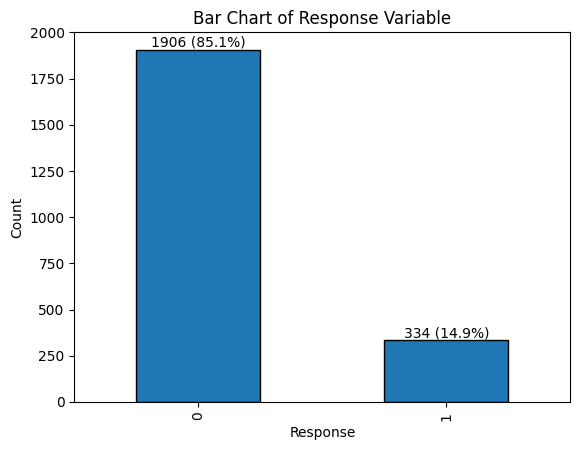

In [8]:
# count the occurrences of each class in 'Response'
response_counts = df3['Response'].value_counts()

# create the bar chart
ax = response_counts.plot(kind='bar', edgecolor='black')

# calculate the total number of observations
total = len(df3['Response'])

# loop through the patches (bars) to add labels
for patch in ax.patches:
    height = patch.get_height()  # Get the height of the bar
    # calculate percentage
    percentage = (height / total) * 100
    # add the count and percentage as a label
    ax.annotate(f'{height} ({percentage:.1f}%)',
                 (patch.get_x() + patch.get_width() / 2., height),
                 ha='center', va='bottom')

# set labels and title
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Bar Chart of Response Variable')

# show the plot
plt.grid(False)
plt.show()

It's worth investigating our response variable in case we have imblanced data. Class imblance is a problem where the total number of one class of data significantly outnumbers the total number of another class of data. In our case, Response **0** significantly outweighs response **1** by a difference of **85%** to **15%**. There are a number of ways to try and balance our dataset, such as over or under sampling
- over-sampling: adding copies of instances to the minority class (Response = 1). Generally used when the dataset is small
- under-sampling: deleting instanceds from the majority calss (Response = 0). Generally used when you have a large dataset

After splitting our data, we will use an over-sampling technique called SMOTE (Synthetic Minority Over-sampling Technique)

### Train Test Split
We will use the training set to train the model and the testing set to evaluate its performance

In [9]:
# separate X and y
X = df3.drop(columns=['Response']) # features
y = df3['Response'] # target variable

# split based on 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Balance Response Classes
We will do this using **SMOTE**

In [10]:
# apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Normalization

**Standard scaler** to scale our numerical values 

In order to avoid Data leakage, we scale our data after we split in to tgest and train. Leakage occurs when information from outside the training dataset is used to create the model.

In [ ]:
# numerical scaling 

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled) #  replace X_train_resampled with X_train if original results without scaled data are desired
X_test_scaled = scaler.transform(X_test)

### Determine the Optimal Value of **K**

1. Set range of K values - this will depend on the dataset size.  Common rule is to use the square root of the number of training samples as an upper bound for K
2. Cross validation - evaluate model performance at each K
3. Plot - plot the cv accuracy for each K value. This helps visualize the "elbow" or point where increasing K no longer significantly improves accuracy.

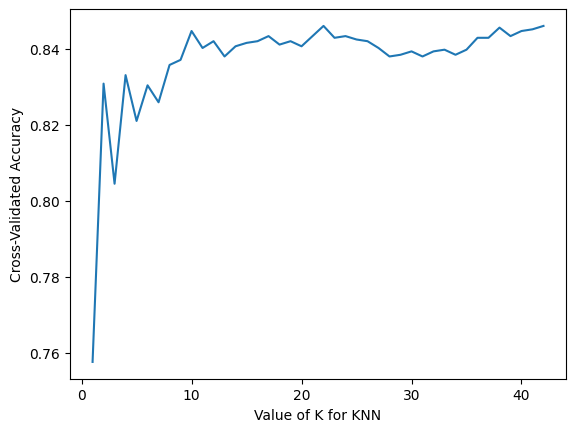

In [12]:
# start by using the square root rule to get Ks upper bound
K_max = math.ceil(math.sqrt(len(X_train)))

# range of K values to test
k_range = range(1, K_max)
k_scores = []

# compute cross-validated accuracy for each value of K
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')  # Use your features (X) and labels (y)
    k_scores.append(scores.mean())

# plot accuracy vs. K value
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

43 is fairly large, but it was a starting point for us to see where accuracy begins to stabilize. We can plot these accuracies again with a smaller upper bound and "zoom in"

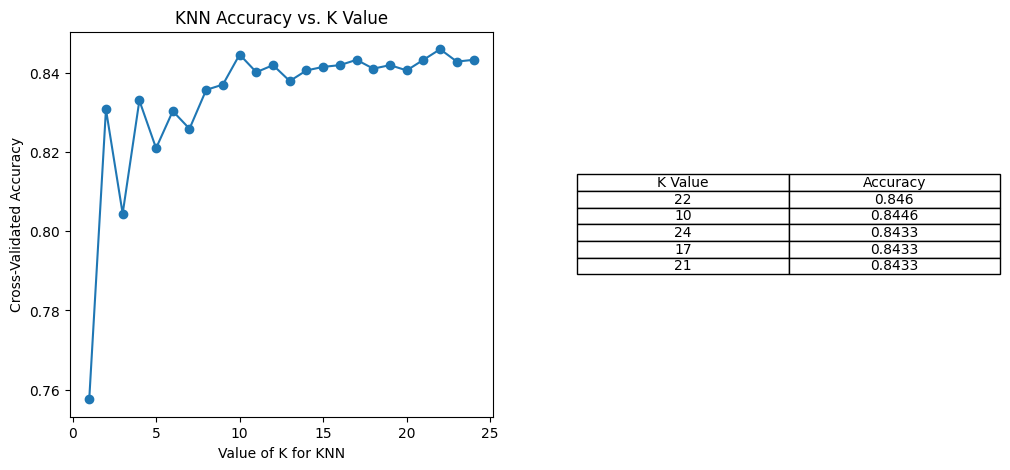

In [13]:
# range of K values to test, try 25 this time
k_range = range(1, 25)
k_scores = []

# compute cross-validated accuracy for each value of K
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')  # Use your features (X) and labels (y)
    k_scores.append(scores.mean())

# find the indices of the top 5 accuracies
top_5_indices = np.argsort(k_scores)[-5:][::-1]  # Get indices of the top 5 accuracies
top_5_k = [k_range[i] for i in top_5_indices]
top_5_scores = [round(k_scores[i], 4) for i in top_5_indices] 

# create a figure with two subplots: one for the line chart and one for the table
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# plot accuracy vs. K value in the first subplot
ax1.plot(k_range, k_scores, marker='o')
ax1.set_xlabel('Value of K for KNN')
ax1.set_ylabel('Cross-Validated Accuracy')
ax1.set_title('KNN Accuracy vs. K Value')

# create a table with the top 5 K values and their accuracies in the second subplot
table_data = [["K Value", "Accuracy"]] + list(zip(top_5_k, top_5_scores))
ax2.axis('tight')
ax2.axis('off')  # Turn off the axis for the table
ax2.table(cellText=table_data, cellLoc='center', loc='center')

# adjust layout for better spacing
plt.show()

We can see the accuracy for the top 5 K values are pretty close. I will choose to proceed with ```K=10``` at ~84% accuracy.

In [ ]:
# step 1:  initialize and fit the KNN model

# initialize the KNN classifier with k=10
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model to the training data
knn.fit(X_train_scaled, y_train_resampled) # replace y_train_resampled with y_train if original results without scaled data are desired

KNeighborsClassifier(n_neighbors=10)

In [15]:
# step 2: make predictions

# make predictions on the test set
y_pred = knn.predict(X_test_scaled)

In [16]:
# step 3: evaluate the model

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8460
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       393
           1       0.40      0.51      0.45        55

    accuracy                           0.85       448
   macro avg       0.66      0.70      0.68       448
weighted avg       0.86      0.85      0.85       448



### Classification Report Interpretation
- Precision: measures how many of the predicted positives (for each class) are true positives
  - Class 0: 0.93 (93%) of the instances predicted as Class 0 are indeed correct
  - Class 1: only 0.40 (40%) of instances predicted as Class 1 are correct. This suggests the model still struggles to correctly identify Class 1. Remember, this is our minority class
- Recall: measures how many of the actual positives (for each class) are correctly predicted
  - Class 0: model correctly identifies 0.89 (89%) of Class 0 instances
  - Class 1: model correctly identifies 0.51 (51%) of Class 1 instances, so, despite SMOTE, it still misses nearly half
- F1-Score: mean of precision and recall, balancing both concerns

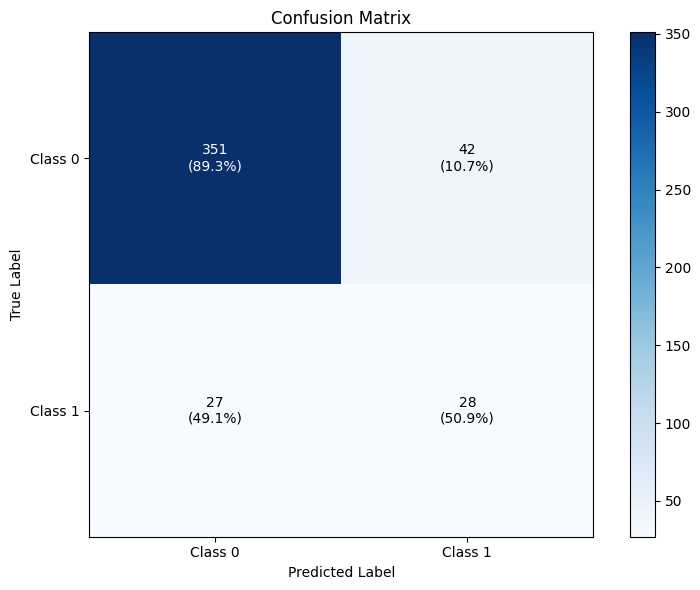

In [17]:
# visualize the confusion matrix

# compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# set up the labels (customize these based on your dataset)
labels = ['Class 0', 'Class 1']  # Replace with your actual class names if needed

# calculate percentages
conf_matrix_percentages = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# create a plot for the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# annotate the matrix with counts and percentages
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    count = conf_matrix[i, j]
    percentage = conf_matrix_percentages[i, j]
    plt.text(j, i, f'{count}\n({percentage:.1f}%)',
             ha="center", va="center",
             color="white" if count > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Correlation Matrix Interpretation

Remember what our response variable represents. 1 if customer accepted the offer in the last campaign (Good/Positive), 0 if they didn't (Bad/ egative)

- True Negatives (351, 89%): The model correctly classified 351 instances of Class 0
- False Positives (42, 11%): 42 instances were incorrectly classified as Class 1 instead of Class 0
- False Negatives (27, 49%): 27 instances of Class 1 were incorrectly classified as Class 0
- True Positives (28, 51%): The model correctly classified 28 instances of Class 1

The model performs well on our majority class (0), but trying to predict our miniority class (1) is no better than a coin flip. 

### Next Steps

This would be a good first try a classification model but as we can see, it's far from perfect. Some things we could consider for further improvement might include tuning K (smaller or larger values), trying different resampling methods (under-sampling instead of over), or experimenting with different classifiers (random forest, SVM, etc.)